## Data Processing

In [47]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore") 
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
pd.options.display.max_colwidth = None

In [48]:
df=pd.read_csv('./data/data.csv',usecols=['title', 'news'])

In [49]:
df.head()

,title,news
0,Jack Carr recalls Gen. Eisenhower's D-Day memo about 'great and noble undertaking',fox
1,"Bruce Willis, Demi Moore avoided doing one thing while co-parenting, daughter says",fox
2,"Blinken meets Qatar PM, says Israeli actions are not 'retaliation,' but 'defending the lives of its people'",fox
3,"Emily Blunt says her ‘toes curl’ when people tell her their kids want to act: 'I want to say, don’t do it!'",fox
4,"'The View' co-host, CNN commentator Ana Navarro to host night 2 of Democratic National Convention",fox


In [50]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove punctuation
    words = word_tokenize(text.lower())
    # Remove stop words and punctuation
    words = [
        word for word in words
        if word.lower() not in stop_words and word not in punctuation and not re.search(r'\d', word)
    ]
    
    # Rejoin words
    return ' '.join(words)

# Apply the function to the 'title' column
df['title'] = df['title'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\26656\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\26656\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [51]:
df

,title,news
0,jack carr recalls gen. eisenhower 's d-day memo 'great noble undertaking,fox
1,bruce willis demi moore avoided one thing co-parenting daughter says,fox
2,blinken meets qatar pm says israeli actions 'retaliation 'defending lives people,fox
3,emily blunt says ‘ toes curl ’ people tell kids want act want say ’,fox
4,'the view co-host cnn commentator ana navarro host night democratic national convention,fox
...,...,...
3800,trump 's lawyers seek post-election day delay court fight immunity decision fallout interference case,nbc
3801,treat acne scars hyperpigmentation according experts,nbc
3802,best vegetarian vegan meal delivery services according experts,nbc
3803,trump says presidential civilian award 'better top military honor whose recipients 'dead 'hit bullets,nbc


In [52]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=41)
X_train = train_df['title']
y_train = train_df['news']
X_test = test_df['title']
y_test = test_df['news']
y_train = y_train.apply(lambda x: 1 if x == 'fox' else 0)
y_test = y_test.apply(lambda x: 1 if x == 'fox' else 0)
accuracy_scores={}

## Word Embedding

### TF-IDF/ Bag of worsd/Bag of ngrams


In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = TfidfVectorizer(max_features=10000) # Adjust max_features if needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
print("Feature Names:", vectorizer.get_feature_names_out())
print(len(vectorizer.vocabulary_))

vectorizer = CountVectorizer() # Adjust max_features if needed
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)
print("Feature Names:", vectorizer.get_feature_names_out())
print(len(vectorizer.vocabulary_))

vectorizer = CountVectorizer(ngram_range=(1, 2))  # Adjust max_features&ngram_range if needed
# Fit and transform the training data, then transform the test data
X_train_bong = vectorizer.fit_transform(X_train)
X_test_bong = vectorizer.transform(X_test)
# Display the feature names (words and n-grams)
print("Feature Names:", vectorizer.get_feature_names_out())
print(len(vectorizer.vocabulary_))

Feature Names: ['aapi' 'aaron' 'abandon' ... 'zuckerberg' 'zyn' 'zzz']
7471
Feature Names: ['aapi' 'aaron' 'abandon' ... 'zuckerberg' 'zyn' 'zzz']
7471
Feature Names: ['aapi' 'aapi owned' 'aaron' ... 'zyn maker' 'zzz' 'zzz amazon']
29715


### Word2Vec

In [54]:
from gensim.models import KeyedVectors
#install scipy<1.13 to be compatible for gensim
#!pip install "scipy<1.13"
word2vec_model = KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin.gz', binary=True,limit=500000)

# Tokenize your text data
X_train_tokenized = [sentence.split() for sentence in X_train]
X_test_tokenized = [sentence.split() for sentence in X_test]

# Define a function to average word vectors for each sentence
def average_word_vectors(sentence, model, vector_size):
    words = [word for word in sentence if word in model]
    return np.mean(model[words], axis=0)
# Apply average word vectors on training and test sets
X_train_word2vec = np.array([average_word_vectors(sentence, word2vec_model, 300) for sentence in X_train_tokenized])
X_test_word2vec = np.array([average_word_vectors(sentence, word2vec_model, 300) for sentence in X_test_tokenized])

### Glove

In [55]:
glove_file = "./data/glove.6B.100d.txt"

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.strip().split(' ')
            word = values[0]
            try:
                vector = np.asarray(values[1:], dtype="float32")
                embeddings[word] = vector
            except ValueError:
                print(f"Skipping line with invalid vector for word: {word}")
    return embeddings
glove_embeddings = load_glove_embeddings(glove_file)

In [56]:

def sentence_to_glove(sentence, embeddings):
    words = sentence.split()
    vectors = [embeddings[word] for word in words if word in embeddings]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(300)  # Return a zero vector if no words are in embeddings

# Transform an entire dataset (e.g., train and test sets)
X_train_glove = np.array([sentence_to_glove(sentence, glove_embeddings) for sentence in X_train])
X_test_glove = np.array([sentence_to_glove(sentence, glove_embeddings) for sentence in X_test])

glove_embeddings = load_glove_embeddings(glove_file)

## Model

### LogisticRegression

In [57]:
# Logistic Regression with TF-IDF
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print("Tfidf With Logistic Regression")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
accuracy_scores["Tfidf With Logistic Regression"] = accuracy

# Logistic Regression with Bag of Words
model = LogisticRegression()
model.fit(X_train_bow, y_train)
y_pred = model.predict(X_test_bow)
accuracy = accuracy_score(y_test, y_pred)
print("Bag Of Word With Logistic Regression")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
accuracy_scores["Bag Of Word With Logistic Regression"] = accuracy

# Logistic Regression with Bag of N-Grams
model = LogisticRegression()
model.fit(X_train_bong, y_train)
y_pred = model.predict(X_test_bong)
accuracy = accuracy_score(y_test, y_pred)
print("Bag Of N Grams With Logistic Regression")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
accuracy_scores["Bag Of N Grams With Logistic Regression"] = accuracy

# Logistic Regression with Word2Vec
model = LogisticRegression()
model.fit(X_train_word2vec, y_train)
y_pred = model.predict(X_test_word2vec)
accuracy = accuracy_score(y_test, y_pred)
print("Word2Vec With Logistic Regression")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
accuracy_scores["Word2Vec With Logistic Regression"] = accuracy

# Logistic Regression with GloVe
model = LogisticRegression()
model.fit(X_train_glove, y_train)
y_pred = model.predict(X_test_glove)
accuracy = accuracy_score(y_test, y_pred)
print("GloVe With Logistic Regression")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
accuracy_scores["GloVe With Logistic Regression"] = accuracy

Tfidf With Logistic Regression
Accuracy: 0.7963
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.72      0.75       330
           1       0.80      0.85      0.83       431

    accuracy                           0.80       761
   macro avg       0.80      0.79      0.79       761
weighted avg       0.80      0.80      0.79       761

Bag Of Word With Logistic Regression
Accuracy: 0.7911
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.76       330
           1       0.83      0.80      0.81       431

    accuracy                           0.79       761
   macro avg       0.79      0.79      0.79       761
weighted avg       0.79      0.79      0.79       761

Bag Of N Grams With Logistic Regression
Accuracy: 0.8003
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.77       330
      

### Decision Tree

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Decision Tree with TF-IDF
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_tfidf, y_train)
y_pred_dt = dt_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_dt)
print("TFIDF with Decision Tree")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
accuracy_scores["TFIDF with Decision Tree"] = accuracy

# Decision Tree with Bag of Words
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_bow, y_train)
y_pred_dt_bow = dt_model.predict(X_test_bow)
accuracy = accuracy_score(y_test, y_pred_dt_bow)
print("Bag of Words with Decision Tree")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_dt_bow))
accuracy_scores["Bag of Words with Decision Tree"] = accuracy

# Decision Tree with Bag of N-grams
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_bong, y_train)
y_pred_dt_bong = dt_model.predict(X_test_bong)
accuracy = accuracy_score(y_test, y_pred_dt_bong)
print("Bag of N-grams with Decision Tree")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_dt_bong))
accuracy_scores["Bag of N-grams with Decision Tree"] = accuracy

# Decision Tree with Word2Vec
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_word2vec, y_train)
y_pred_dt_word2vec = dt_model.predict(X_test_word2vec)
accuracy = accuracy_score(y_test, y_pred_dt_word2vec)
print("Word2Vec with Decision Tree")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_dt_word2vec))
accuracy_scores["Word2Vec With DecisionTree"] = accuracy

# Decision Tree with GloVe
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_glove, y_train)
y_pred_dt_glove = dt_model.predict(X_test_glove)
accuracy = accuracy_score(y_test, y_pred_dt_glove)
print("GloVe with Decision Tree")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_dt_glove))
accuracy_scores["GloVe with Decision Tree"] = accuracy

TFIDF with Decision Tree
Accuracy: 0.7359
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.76      0.71       330
           1       0.80      0.71      0.75       431

    accuracy                           0.74       761
   macro avg       0.73      0.74      0.73       761
weighted avg       0.74      0.74      0.74       761

Bag of Words with Decision Tree
Accuracy: 0.7464
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.70      0.71       330
           1       0.77      0.78      0.78       431

    accuracy                           0.75       761
   macro avg       0.74      0.74      0.74       761
weighted avg       0.75      0.75      0.75       761

Bag of N-grams with Decision Tree
Accuracy: 0.7424
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.69      0.70       330
           1       0.77

### Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Random Forest with TF-IDF
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_rf)
print("TFIDF with Random Forest")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
accuracy_scores["TFIDF with Random Forest"] = accuracy

# Random Forest with Bag of Words
rf_model = RandomForestClassifier()
rf_model.fit(X_train_bow, y_train)
y_pred_rf_bow = rf_model.predict(X_test_bow)
accuracy = accuracy_score(y_test, y_pred_rf_bow)
print("Bag of Words with Random Forest")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf_bow))
accuracy_scores["Bag of Words with Random Forest"] = accuracy

# Random Forest with Bag of N-grams
rf_model = RandomForestClassifier()
rf_model.fit(X_train_bong, y_train)
y_pred_rf_bong = rf_model.predict(X_test_bong)
accuracy = accuracy_score(y_test, y_pred_rf_bong)
print("Bag of N-grams with Random Forest")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf_bong))
accuracy_scores["Bag of N-grams with Random Forest"] = accuracy

# Random Forest with Word2Vec
rf_model = RandomForestClassifier()
rf_model.fit(X_train_word2vec, y_train)
y_pred_rf_w2c = rf_model.predict(X_test_word2vec)
accuracy = accuracy_score(y_test, y_pred_rf_w2c)
print("Word2Vec with Random Forest")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf_w2c))
accuracy_scores["Word2Vec With RandomForest"] = accuracy

# Random Forest with GloVe
rf_model = RandomForestClassifier()
rf_model.fit(X_train_glove, y_train)
y_pred_rf_glove = rf_model.predict(X_test_glove)
accuracy = accuracy_score(y_test, y_pred_rf_glove)
print("GloVe with Random Forest")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf_glove))
accuracy_scores["GloVe with Random Forest"] = accuracy

TFIDF with Random Forest
Accuracy: 0.7753
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.75      0.74       330
           1       0.81      0.79      0.80       431

    accuracy                           0.78       761
   macro avg       0.77      0.77      0.77       761
weighted avg       0.78      0.78      0.78       761

Bag of Words with Random Forest
Accuracy: 0.7924
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.77       330
           1       0.83      0.80      0.81       431

    accuracy                           0.79       761
   macro avg       0.79      0.79      0.79       761
weighted avg       0.79      0.79      0.79       761

Bag of N-grams with Random Forest
Accuracy: 0.7989
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.78       330
           1       0.84

### SVM

In [60]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# SVM with TFIDF
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_svm)
print("TFIDF with SVM")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_svm))
accuracy_scores["TFIDF with SVM"] = accuracy

# SVM with Bag of Words
svm_model = SVC()
svm_model.fit(X_train_bow, y_train)
y_pred_svm_bow = svm_model.predict(X_test_bow)
accuracy = accuracy_score(y_test, y_pred_svm_bow)
print("Bag of Words with SVM")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_svm_bow))
accuracy_scores["Bag of Words with SVM"] = accuracy

# SVM with Bag of N-grams
svm_model = SVC()
svm_model.fit(X_train_bong, y_train)
y_pred_svm_bong = svm_model.predict(X_test_bong)
accuracy = accuracy_score(y_test, y_pred_svm_bong)
print("Bag of N-grams with SVM")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_svm_bong))
accuracy_scores["Bag of N-grams with SVM"] = accuracy

# SVM with Word2Vec
svm_model = SVC()
svm_model.fit(X_train_word2vec, y_train)
y_pred_svm_w2v = svm_model.predict(X_test_word2vec)
accuracy = accuracy_score(y_test, y_pred_svm_w2v)
print("Word2Vec with SVM")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_svm_w2v))
accuracy_scores["Word2Vec With SVM"] = accuracy

# SVM with GloVe
svm_model = SVC()
svm_model.fit(X_train_glove, y_train)
y_pred_svm_glove = svm_model.predict(X_test_glove)
accuracy = accuracy_score(y_test, y_pred_svm_glove)
print("GloVe with SVM")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_svm_glove))
accuracy_scores["GloVe with SVM"] = accuracy

TFIDF with SVM
Accuracy: 0.8095
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77       330
           1       0.80      0.88      0.84       431

    accuracy                           0.81       761
   macro avg       0.81      0.80      0.80       761
weighted avg       0.81      0.81      0.81       761

Bag of Words with SVM
Accuracy: 0.7832
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.86      0.78       330
           1       0.87      0.72      0.79       431

    accuracy                           0.78       761
   macro avg       0.79      0.79      0.78       761
weighted avg       0.80      0.78      0.78       761

Bag of N-grams with SVM
Accuracy: 0.5742
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.97      0.66       330
           1       0.91      0.27      0.42       431

### Naive Bayes

In [61]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Naive Bayes with TF-IDF
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb_tfidf = nb_model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_nb_tfidf)
print("TFIDF with Naive Bayes")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_nb_tfidf))
accuracy_scores["TFIDF with Naive Bayes"] = accuracy

# Naive Bayes with Bag of Words
nb_model = MultinomialNB()
nb_model.fit(X_train_bow, y_train)
y_pred_nb_bow = nb_model.predict(X_test_bow)
accuracy = accuracy_score(y_test, y_pred_nb_bow)
print("Bag of Words with Naive Bayes")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_nb_bow))
accuracy_scores["Bag of Words with Naive Bayes"] = accuracy

# Naive Bayes with Bag of N-grams
nb_model = MultinomialNB()
nb_model.fit(X_train_bong, y_train)
y_pred_nb_bong = nb_model.predict(X_test_bong)
accuracy = accuracy_score(y_test, y_pred_nb_bong)
print("Bag of N-grams with Naive Bayes")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_nb_bong))
accuracy_scores["Bag of N-grams with Naive Bayes"] = accuracy

# Naive Bayes with Word2Vec (using GaussianNB)
nb_model = GaussianNB()
nb_model.fit(X_train_word2vec, y_train)
y_pred_nb_w2v = nb_model.predict(X_test_word2vec)
accuracy = accuracy_score(y_test, y_pred_nb_w2v)
print("Word2Vec with Naive Bayes (GaussianNB)")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_nb_w2v))
accuracy_scores["Word2Vec with Naive Bayes"] = accuracy

# Naive Bayes with GloVe (using GaussianNB)
nb_model = GaussianNB()
nb_model.fit(X_train_glove, y_train)
y_pred_nb_glove = nb_model.predict(X_test_glove)
accuracy = accuracy_score(y_test, y_pred_nb_glove)
print("GloVe with Naive Bayes (GaussianNB)")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_nb_glove))
accuracy_scores["GloVe with Naive Bayes"] = accuracy

TFIDF with Naive Bayes
Accuracy: 0.8029
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77       330
           1       0.82      0.84      0.83       431

    accuracy                           0.80       761
   macro avg       0.80      0.80      0.80       761
weighted avg       0.80      0.80      0.80       761

Bag of Words with Naive Bayes
Accuracy: 0.8055
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.78       330
           1       0.83      0.83      0.83       431

    accuracy                           0.81       761
   macro avg       0.80      0.80      0.80       761
weighted avg       0.81      0.81      0.81       761

Bag of N-grams with Naive Bayes
Accuracy: 0.8200
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.77      0.79       330
           1       0.83      

## LSTM

Epoch 1/7
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5328 - loss: 0.6895 - val_accuracy: 0.5900 - val_loss: 0.6790
Epoch 2/7
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5745 - loss: 0.6815 - val_accuracy: 0.5913 - val_loss: 0.6692
Epoch 3/7
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5847 - loss: 0.6711 - val_accuracy: 0.5650 - val_loss: 0.6749
Epoch 4/7
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5693 - loss: 0.6708 - val_accuracy: 0.5926 - val_loss: 0.6621
Epoch 5/7
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6075 - loss: 0.6635 - val_accuracy: 0.5808 - val_loss: 0.6804
Epoch 6/7
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6228 - loss: 0.6610 - val_accuracy: 0.6189 - val_loss: 0.6486
Epoch 7/7
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6473 - loss: 0.6361 - val_accuracy: 0.6452 - val_loss: 0.6355
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6570 - loss: 0.6246
Test Loss: 0.6354852318763733
Test Accuracy: 0.64520

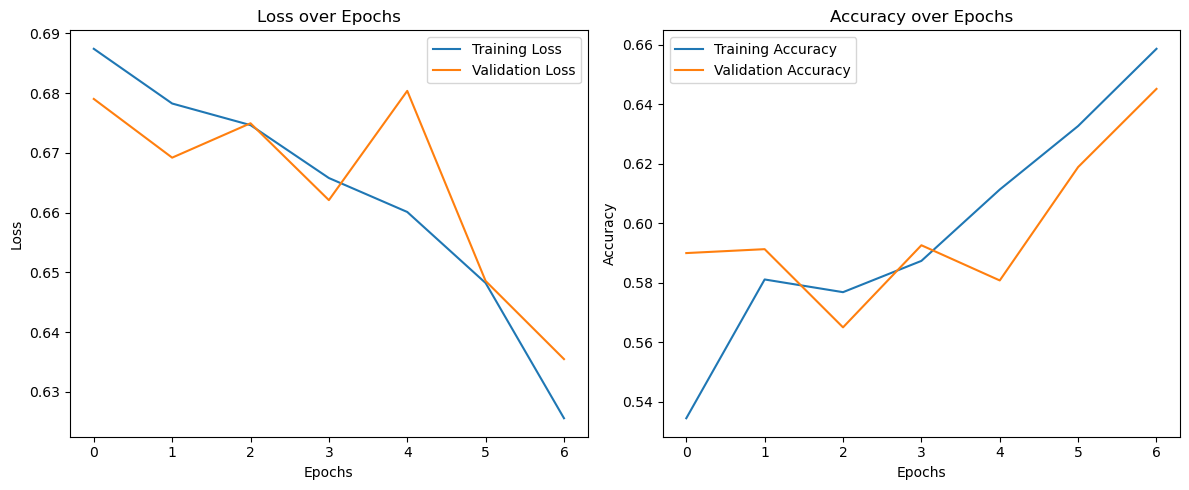

In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from gensim.models import Word2Vec
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D


# Encode labels
le = LabelEncoder()
df['news'] = le.fit_transform(df['news'])

# Tokenize the titles
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['title'])
sequences = tokenizer.texts_to_sequences(df['title'])
word_index = tokenizer.word_index

# Padding sequences
max_len = max(len(x) for x in sequences)
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = df['news'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Word2Vec model on the training set only
sentences_train = [df['title'][i].split() for i in range(len(X_train))]
word2vec_model = Word2Vec(sentences_train, vector_size=100, window=5, min_count=1, workers=4)

# Create embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
#-------------------------------
# Updated LSTM Model
# Simple LSTM Model
model = Sequential()

# Embedding layer with pre-trained Word2Vec weights
model.add(Embedding(input_dim=len(word_index) + 1, 
                    output_dim=100, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))

# Single LSTM layer
model.add(LSTM(64))

# Dropout for regularization
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#---------------------

history=model.fit(X_train, y_train, epochs=7, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
accuracy_scores['Word2Vec With LSTM']=accuracy
def plot_metrics(history):
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot_metrics function
plot_metrics(history)

Epoch 1/4
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6058 - loss: 0.6551 - val_accuracy: 0.7464 - val_loss: 0.5403
Epoch 2/4
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7596 - loss: 0.5191 - val_accuracy: 0.7753 - val_loss: 0.4963
Epoch 3/4
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7911 - loss: 0.4699 - val_accuracy: 0.7595 - val_loss: 0.5263
Epoch 4/4
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7930 - loss: 0.4336 - val_accuracy: 0.7792 - val_loss: 0.4751
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7903 - loss: 0.4574 
Test Loss: 0.4751305878162384
Test Accuracy: 0.7792378664016724


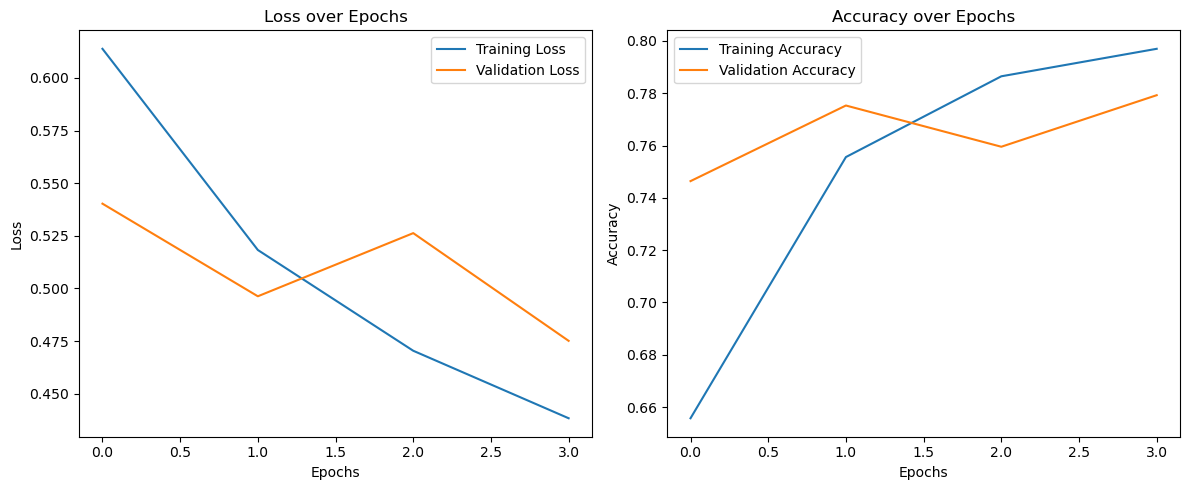

In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Load your dataset (assuming df is your DataFrame with 'title' and 'news' columns)
# df = pd.read_csv('your_dataset.csv')

# Encode labels
le = LabelEncoder()
df['news'] = le.fit_transform(df['news'])

# Tokenize the titles
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['title'])
sequences = tokenizer.texts_to_sequences(df['title'])
word_index = tokenizer.word_index

# Padding sequences
max_len = max(len(x) for x in sequences)
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = df['news'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load GloVe embeddings
embedding_dim = 100
glove_path = "./data/glove.6B.100d.txt"  # Update this path with the correct location of your GloVe file

# Create an embedding index
embedding_index = {}
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs

# Create the embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Build the simple LSTM model
model = Sequential()

# Embedding layer with pre-trained GloVe weights
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))

# Single LSTM layer
model.add(LSTM(64))

# Dropout for regularization
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history=model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
accuracy_scores['Glove With LSTM']=accuracy
def plot_metrics(history):
    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot_metrics function
plot_metrics(history)

In [64]:
ranked_models = sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True)

In [65]:
ranked_models

[('Bag of N-grams with Naive Bayes', 0.8199737187910644),
 ('TFIDF with SVM', 0.80946123521682),
 ('Bag of Words with Naive Bayes', 0.8055190538764783),
 ('TFIDF with Naive Bayes', 0.8028909329829172),
 ('Bag Of N Grams With Logistic Regression', 0.8002628120893561),
 ('Bag of N-grams with Random Forest', 0.7989487516425755),
 ('Tfidf With Logistic Regression', 0.7963206307490145),
 ('Bag of Words with Random Forest', 0.7923784494086727),
 ('Bag Of Word With Logistic Regression', 0.7910643889618922),
 ('Bag of Words with SVM', 0.783180026281209),
 ('Glove With LSTM', 0.7792378664016724),
 ('Word2Vec With SVM', 0.7792378449408672),
 ('TFIDF with Random Forest', 0.7752956636005256),
 ('GloVe with SVM', 0.7621550591327201),
 ('Bag of Words with Decision Tree', 0.7463863337713534),
 ('Bag of N-grams with Decision Tree', 0.7424441524310118),
 ('Word2Vec With RandomForest', 0.7411300919842313),
 ('TFIDF with Decision Tree', 0.735873850197109),
 ('Word2Vec With Logistic Regression', 0.7293035